# 0. Create data folder

In [26]:
import os
import random
import shutil

original_folders = ['/kaggle/input/real-vs-ai-generated-human-faces/RealHuman', '/kaggle/input/real-vs-ai-generated-human-faces/FakeHuman']

train_folder = '/kaggle/working/train'
validate_folder = '/kaggle/working/validate'
test_folder = '/kaggle/working/test'


if not os.path.exists(train_folder):
    os.makedirs(train_folder)
    
if not os.path.exists(validate_folder):
    os.makedirs(validate_folder)
    
if not os.path.exists(test_folder):  
    os.makedirs(test_folder)
    
for i in range(len(original_folders)):
    
    images = os.listdir(original_folders[i])
    num_images = len(images)
    
    num_train = int(0.6 * num_images)
    num_validate = int(0.2 * num_images) 
    num_test = int(0.2 * num_images)

    random.shuffle(images)

    train_images = images[:num_train]
    validate_images = images[num_train:num_train+num_validate]
    test_images = images[-num_test:]
    
    # ----
    train_subfolder_path = os.path.join(train_folder, str(i))  
    if not os.path.exists(train_subfolder_path):
        os.makedirs(train_subfolder_path)
        
    validate_subfolder_path = os.path.join(validate_folder, str(i))  
    if not os.path.exists(validate_subfolder_path):
        os.makedirs(validate_subfolder_path)
        
    test_subfolder_path = os.path.join(test_folder, str(i))
    if not os.path.exists(test_subfolder_path):
        os.makedirs(test_subfolder_path)
        
    for img in train_images:
        shutil.copy(os.path.join(original_folders[i], img), 
                    train_subfolder_path)
        
    for img in validate_images:
        shutil.copy(os.path.join(original_folders[i], img), 
                    validate_subfolder_path)
        
    for img in test_images:
        shutil.copy(os.path.join(original_folders[i], img),  
                    test_subfolder_path)
    

# 1. Load data

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [28]:
# Define class to generate data from image
class DataGenerator():
    def __init__(self, batch_size, target_size=(224, 224)):
        self.batch_size = batch_size
        self.target_size = target_size

    def generate_data(self, mode, shuffle=True):
        if mode == 'train':
            data_path = '/kaggle/working/train'

        elif mode == 'validation':
            data_path = '/kaggle/working/validate'

        elif mode == 'test':
            data_path = '/kaggle/working/test'

        else:
            raise ValueError('Invalid mode: %s' % mode)

        data_gen = ImageDataGenerator(rescale=1./255)

        data_set = data_gen.flow_from_directory(
            data_path,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=shuffle,
            seed=42,
            classes=['0', '1'],
        )

        print(data_set.class_indices)
        return data_set

In [29]:
batch_size = 256
target_size=(224, 224)
data_gen = DataGenerator(batch_size, target_size)

train_set = data_gen.generate_data('train', shuffle=True)
val_set = data_gen.generate_data('validation', shuffle=True)
test_set = data_gen.generate_data('test', shuffle= False)

Found 8323 images belonging to 2 classes.
{'0': 0, '1': 1}
Found 2774 images belonging to 2 classes.
{'0': 0, '1': 1}
Found 2774 images belonging to 2 classes.
{'0': 0, '1': 1}


# 2. Define model

## 2.2. Transfer learning with pre-trained models

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.applications import VGG19, MobileNet, EfficientNetB0, ResNet50, DenseNet121, RegNetX002

class CustomModels:
    """Custom Model Class"""
    
    def __init__(self, num_classes=1000, input_shape=(224, 224, 3), name= 'resnet'):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.name = name

    def build(self):
        if "vgg" in self.name:
            base_model = VGG19(include_top = False, weights = 'imagenet')

        elif "mobilenet" in self.name:
            base_model = MobileNet(include_top = False, weights = 'imagenet')

        elif "efficientnet" in self.name:
            base_model = EfficientNetB0(include_top = False, weights = 'imagenet')

        elif "resnet" in self.name:
            base_model = ResNet50(include_top = False, weights = 'imagenet')

        elif "densenet" in self.name:
            base_model = DenseNet121(include_top = False, weights = 'imagenet')

        elif "regnet" in self.name:
            base_model = RegNetX002(include_top = False, weights = 'imagenet')

        
        base_model.trainable = False
        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training = False)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.2)(x)
        x = Dense(units = 1024, activation = 'relu')(x)
        outputs = Dense(units = self.num_classes, activation = 'softmax')(x)
        model = Model(inputs=inputs, outputs=outputs, name=self.name)
        return model
    

            

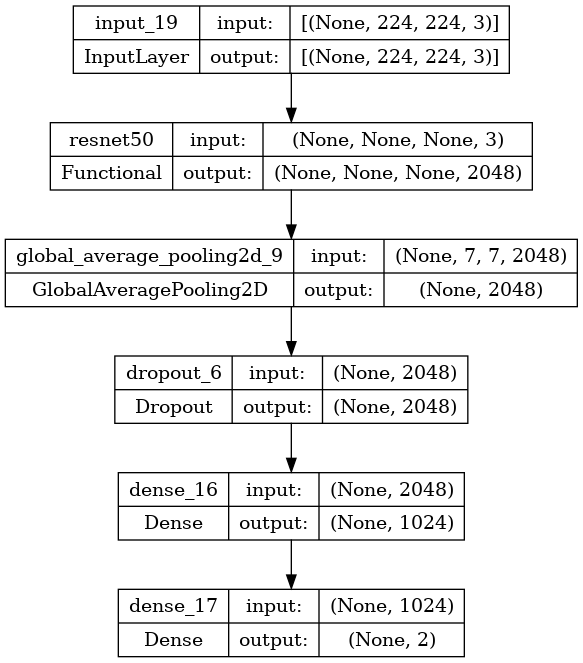

In [39]:
resnet50_pretrained = CustomModels(num_classes = 2).build()

from tensorflow.keras.utils import plot_model
plot_model(resnet50_pretrained, show_shapes = True)

In [40]:
resnet50_pretrained.summary()

Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 2)                 2050      
                                                            

# 3. Train model

## 3.1 Define trainer

In [41]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import json
import os

class Trainer:
    def __init__(self, model, loss, optimizer=Adam(learning_rate = 0.001), metrics=['accuracy']):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.history = None


    def compile(self):
        """
        Method to compile model with optimizer, loss and metrics
        """
        self.model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=self.metrics)


    def fit(self, train_set, val_set, batch_size, epochs, callbacks = []):
        """
        Method to train model with dataset and return history
        """
        train_history = self.model.fit(train_set,
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 validation_data = val_set,
                                 callbacks = callbacks)
        # history
        self.history = train_history.history


    def plot_history(self):
        """
        Method to plot model training history
        """

        fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

        axes[0].plot(self.history['accuracy'])
        axes[0].plot(self.history['val_accuracy'])
        axes[0].set_ylabel('Accuracy')
        axes[1].plot(self.history['loss'])
        axes[1].plot(self.history['val_loss'])

        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')

        fig.suptitle('Model performance during training')
        axes[0].legend(('Train accuracy', 'Validation accuracy'))
        axes[1].legend(('Train loss', 'Validation loss'))


    def save_model(self, path = '/kaggle/working/'):
        """
        Method to save model after training
        """
        save_path = os.path.join(path, self.model.name)

        self.model.save(save_path)
        return save_path


## 3.3. Train pre-trained ResNet50

In [42]:
# Define hyperparameters for model trainer
learning_rate = 0.001
optimizer = Adam(learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 256
epochs = 10

In [43]:
# Compile and train model
trainer_resnet_pretrained = Trainer(resnet50_pretrained, loss, optimizer, metrics)

# Compile model
trainer_resnet_pretrained.compile()

# Train model
trainer_resnet_pretrained.fit(train_set = train_set, val_set = val_set, batch_size = batch_size, epochs = epochs)

Epoch 1/10
33/33 [==============================] - 386s 12s/step - loss: 0.8834 - accuracy: 0.5071 - val_loss: 0.6815 - val_accuracy: 0.5559
Epoch 2/10
33/33 [==============================] - 374s 11s/step - loss: 0.6842 - accuracy: 0.5515 - val_loss: 0.6611 - val_accuracy: 0.6179
Epoch 3/10
33/33 [==============================] - 372s 11s/step - loss: 0.6688 - accuracy: 0.5783 - val_loss: 0.6596 - val_accuracy: 0.5609
Epoch 4/10
33/33 [==============================] - 372s 11s/step - loss: 0.6641 - accuracy: 0.5862 - val_loss: 0.6439 - val_accuracy: 0.6424
Epoch 5/10
33/33 [==============================] - 373s 11s/step - loss: 0.6599 - accuracy: 0.5910 - val_loss: 0.6390 - val_accuracy: 0.6370
Epoch 6/10
33/33 [==============================] - 367s 11s/step - loss: 0.6531 - accuracy: 0.6128 - val_loss: 0.6420 - val_accuracy: 0.6182
Epoch 7/10
33/33 [==============================] - 363s 11s/step - loss: 0.6509 - accuracy: 0.6130 - val_loss: 0.6459 - val_accuracy: 0.6096
Epoch 

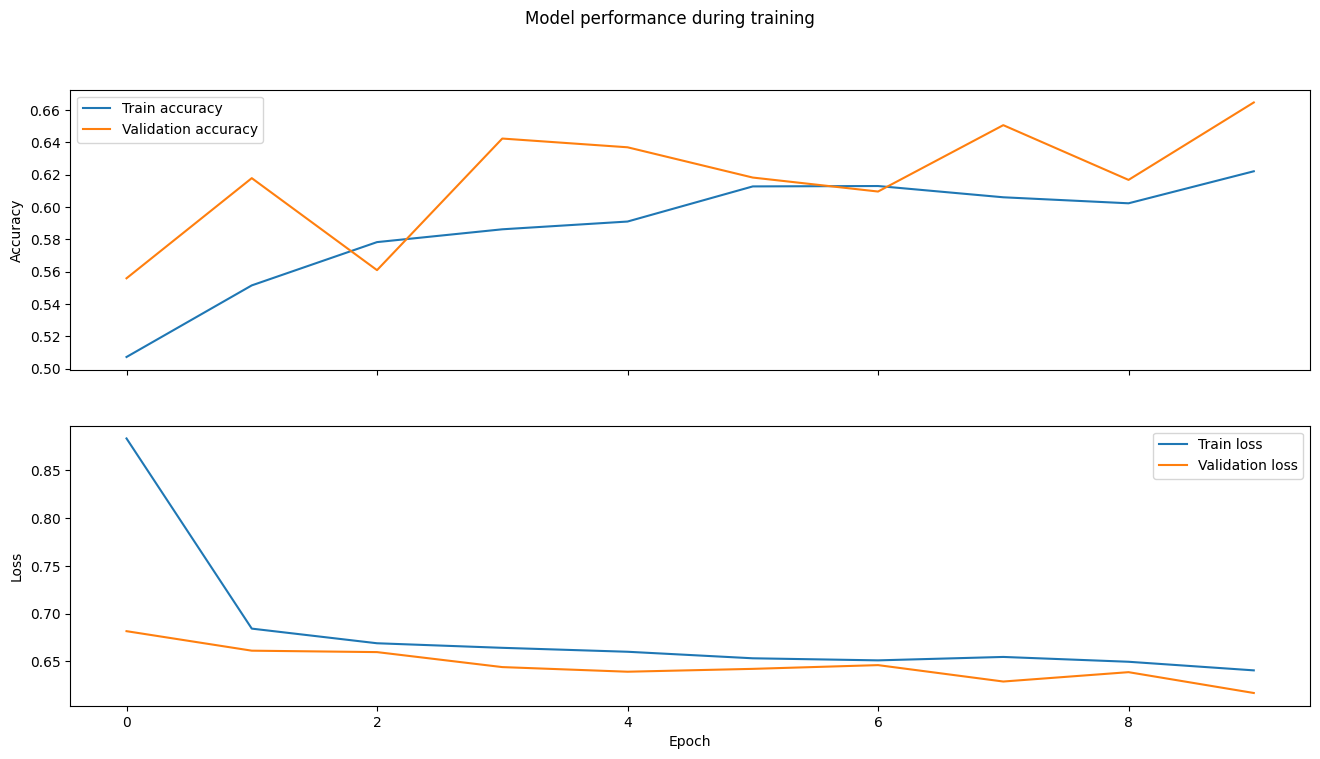

In [44]:
trainer_resnet_pretrained.plot_history()

# 4. Evaluate model

## 4.1 Define evaluator

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

class Evaluator:

    def __init__(self, model, test_set):
        self.model = model

        self.test_loss, self.test_acc = self.model.evaluate(test_set, verbose=1)

        y_pred = self.model.predict(test_set)
        y_true = test_set.classes
        y_pred = np.argmax(y_pred, axis=1)

        self.cm = confusion_matrix(y_true, y_pred)

        self.report = classification_report(y_true, y_pred)

    def evaluate(self):
        """
        Method to evaluate model and return loss and accuracy
        """
        # print("Loss of test set is:", self.test_loss)
        # print("Accuracy of test set is:", self.test_acc)
        return self.test_loss, self.test_acc

    def confusion_matrix(self):
        """
        Method to plot confusion matrix
        """
        sns.heatmap(self.cm, annot=True, fmt="d")
        plt.show()

    def classification_report(self):
        """
        Method to print classification report on test set
        """
        return self.report


## 4.2 Evaluate pre-trained models

In [46]:
evaluate_pretrained = Evaluator(resnet50_pretrained, test_set)

11/11 [==============================] - 92s 9s/step


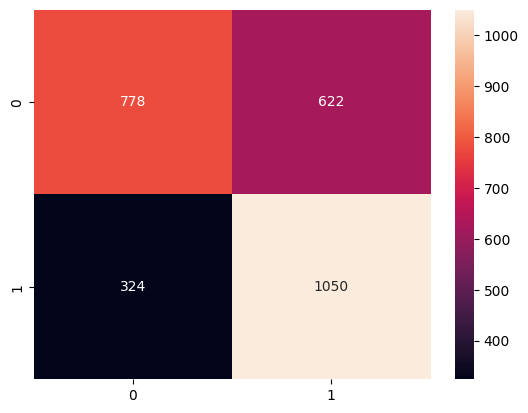

In [47]:
evaluate_pretrained.confusion_matrix()

In [48]:
print(evaluate_pretrained.classification_report())

              precision    recall  f1-score   support

           0       0.71      0.56      0.62      1400
           1       0.63      0.76      0.69      1374

    accuracy                           0.66      2774
   macro avg       0.67      0.66      0.66      2774
weighted avg       0.67      0.66      0.66      2774

